In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Epigenetic age prediction with AltumAge
https://github.com/rsinghlab/AltumAge

Citation: de Lima, Lucas Paulo, Louis R. Lapierre, and Ritambhara Singh. "AltumAge: A Pan-Tissue DNA-Methylation Epigenetic Clock Based on Deep Learning." bioRxiv (2021).

In [187]:
AltumAge_cpgs = np.array(pd.read_pickle('AltumAge/multi_platform_cpgs.pkl'))
AltumAge = tf.keras.models.load_model('AltumAge/AltumAge.h5')
scaler = pd.read_pickle('AltumAge/scaler.pkl')

In [425]:
# plot here is based on the one seen here: https://horvath.genetics.ucla.edu/html/dnamage/TUTORIAL1.pdf
def plot_epi_chrono(epi, chrono, line=True):
    x = np.array(epi)
    y = np.array(chrono)
    medianAbsDev = np.median(abs(x-y))
    cor = stats.pearsonr(x, y)[0]
    p_val = stats.pearsonr(x, y)[1]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(x,y)
    ax.set(xlabel = 'Epigenetic age',ylabel='Chronological age')
    if line==True:
        plt.plot(x, x + 1, '--c')
    ax.set_title(('MAD={:.2g} correlation={:.2g}, p-val={:.2g}').format(medianAbsDev, cor, p_val))
    plt.show

In [179]:
data_meta = pd.read_csv('data/covidGSE167202_meta.csv')

#### With native (normal-exponential out-of-band) normalization:
(not recommended for AltumAge)

In [428]:
data_norm = pd.read_csv('data/covidGSE167202_original.csv')
temp = data_norm.T
temp.columns = data_norm.iloc[:,0]
data_norm = temp.iloc[1:]
data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge = AltumAge.predict(methylation_data_scaled).flatten()

In [429]:
chrono_age = data_meta['age:ch1']

C:\Users\olyam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


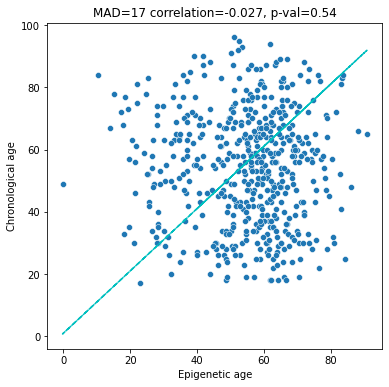

In [430]:
plot_epi_chrono(pred_age_AltumAge, chrono_age)

Not using BMIQ normalization resulted in epigenetic age predictions that don't seem to correlate with chronological age

#### With BMIQ normalization:

In [470]:
data_meta = pd.read_csv('data/covidGSE167202_meta.csv')
data_norm = pd.read_csv('data/covidGSE167202_normalized.csv')

data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge = AltumAge.predict(methylation_data_scaled).flatten()

C:\Users\olyam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


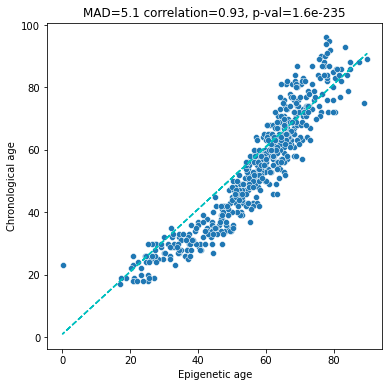

In [471]:
plot_epi_chrono(pred_age_AltumAge, chrono_age)

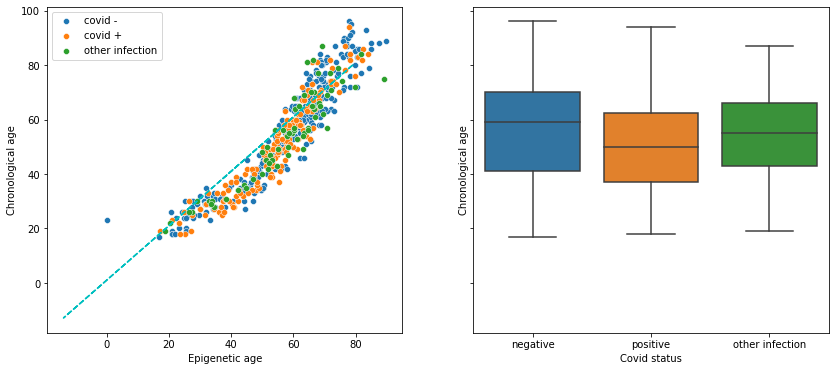

In [1119]:
covid_n_age = chrono_age[data_meta['covid_status:ch1'] == 'negative']
covid_n_altum = pred_age_AltumAge[data_meta['covid_status:ch1'] == 'negative']
covid_o_age = chrono_age[data_meta['covid_status:ch1'] == 'other infection']
covid_o_altum = pred_age_AltumAge[data_meta['covid_status:ch1'] == 'other infection']
covid_p_age = chrono_age[data_meta['covid_status:ch1'] == 'positive']
covid_p_altum = pred_age_AltumAge[data_meta['covid_status:ch1'] == 'positive']

fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
                        
sns.scatterplot(ax=axs[0],x=covid_n_altum,y=covid_n_age,label='covid -')
sns.scatterplot(ax=axs[0],x=covid_p_altum,y=covid_p_age,label='covid +')
sns.scatterplot(ax=axs[0],x=covid_o_altum,y=covid_o_age,label='other infection')
axs[0].set(xlabel = 'Epigenetic age',ylabel='Chronological age')
axs[0].plot(x, x + 1, '--c')
sns.boxplot(ax=axs[1],x=data_meta['covid_status:ch1'], y = data_meta['age:ch1'] )
axs[1].set(xlabel = 'Covid status',ylabel='Chronological age')
_ = plt.plot()

The correlation between epigenetic age and chronological age is much better with BMIQ normalization, but epigenetic age predictions don't seem to be uniform across chronological age for both covid negative and covid positive samples in this dataset. Especially since the chronological age distribution of covid negative and positive is not identical and the covid positive set appears to have proportionately more young samples than the covid negative set, this may cause some issues with comparing epigenetic age acceleration between both sets.

I will use the "other infection" sample set (n=65) to fit a curve to adjust epigenetic age predictions across chronological age and will do comparisons only between covid negative (n=296) and covid positive (n=164) samples:

In [1100]:
z = np.polyfit(x=pred_age_AltumAge[data_meta['covid_status:ch1'] == 'other infection'], 
               y=chrono_age[data_meta['covid_status:ch1'] == 'other infection'],deg=4)
p = np.poly1d(z)
adjusted_altum_preds = p(pred_age_AltumAge)

In [1087]:
# # potential alternative of curve-fitting with part of the covid negative samples:

# covid_negative_for_polyfit = np.random.choice(data_meta.index[data_meta['covid_status:ch1'] == 'negative'], size=100, replace=False)
# covid_polyfit_altum = pred_age_AltumAge[data_meta.index.isin(covid_negative_for_polyfit)]
# covid_polyfit_age = data_meta['age:ch1'][data_meta.index.isin(covid_negative_for_polyfit)]

# data = data.drop(index=covid_negative_for_polyfit)

# z = np.polyfit(x=covid_polyfit_altum, 
#                y=covid_polyfit_age,deg=4)
# p = np.poly1d(z)
# adjusted_altum_preds = p(data['altum'])

# data['adjusted_altum'] = adjusted_altum_preds
# diffs = adjusted_altum_preds - data['age:ch1']

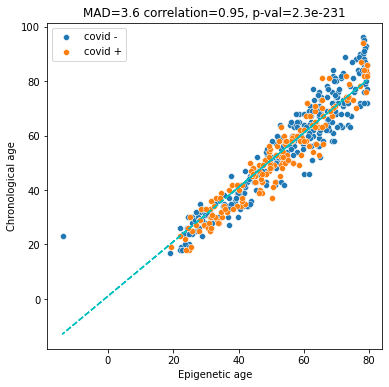

In [1118]:
covid_n_age = data_meta['age:ch1'][data_meta['covid_status:ch1'] == 'negative']
covid_n_altum = adjusted_altum_preds[data_meta['covid_status:ch1'] == 'negative']
covid_p_age = data_meta['age:ch1'][data_meta['covid_status:ch1'] == 'positive']
covid_p_altum = adjusted_altum_preds[data_meta['covid_status:ch1'] == 'positive']

x = adjusted_altum_preds[data_meta['covid_status:ch1'] != 'other infection']
y = data_meta['age:ch1'][data_meta['covid_status:ch1'] != 'other infection']

medianAbsDev = np.median(abs(x-y))
cor = stats.pearsonr(x,y)[0]
p_val = stats.pearsonr(x,y)[1]

fig, axs = plt.subplots(figsize=(6,6), sharey=True)
                        
sns.scatterplot(x=covid_n_altum,y=covid_n_age,label='covid -')
sns.scatterplot(x=covid_p_altum,y=covid_p_age,label='covid +')
axs.set(xlabel = 'Epigenetic age',ylabel='Chronological age')
axs.set_title(('MAD={:.2g} correlation={:.2g}, p-val={:.2g}').format(medianAbsDev, cor, p_val))
axs.plot(x, x + 1, '--c')
_ = plt.plot()

#### Saving meta data file with AltumAge epigenetic age:

In [1104]:
data = data_meta.filter(['title','geo_accession',
                        'covid_status:ch1','severity score:ch1','patient_asymptomatic:ch1',
                        'admitted_to_icu:ch1','covid_hosp_days:ch1','discharged_to:ch1','ed_disposition:ch1',
                        'ethnicity:ch1','race:ch1','Sex:ch1',
                        'age:ch1'])
data['altum'] = pred_age_AltumAge
data['adjusted_altum'] = adjusted_altum_preds
diffs = adjusted_altum_preds - data['age:ch1']
data['diffs'] = diffs

In [1105]:
data.to_csv('data_with_epi_age.csv', index=False)

#### Some data visualization and stats:

In [1106]:
data = pd.read_csv('data_with_epi_age.csv')

In [1107]:
data.head()

,title,geo_accession,covid_status:ch1,severity score:ch1,patient_asymptomatic:ch1,admitted_to_icu:ch1,covid_hosp_days:ch1,discharged_to:ch1,ed_disposition:ch1,ethnicity:ch1,race:ch1,Sex:ch1,age:ch1,altum,adjusted_altum,diffs
0,genomic DNA from peripheral blood SARS-COV-2- 77,GSM5098953,negative,NaN,NaN,No,NaN,Home,Floor Admission,Not Hispanic or Latino,White,Female,27,44.402985,37.180832,10.180832
1,genomic DNA from peripheral blood SARS-COV-2- 124,GSM5098954,negative,NaN,NaN,No,NaN,Home,Discharged,Hispanic or Latino,Other,Male,34,48.271767,41.256850,7.256851
2,genomic DNA from peripheral blood SARS-COV-2+ 155,GSM5098955,positive,2.0,No,No,1.0,Home,Floor Admission,Hispanic or Latino,Other,Female,53,56.823288,52.272680,-0.727322
3,genomic DNA from peripheral blood SARS-COV-2+ 139,GSM5098956,positive,2.0,No,No,4.0,Home,Floor Admission,Hispanic or Latino,Other,Female,34,47.963432,40.908936,6.908936
4,genomic DNA from peripheral blood SARS-COV-2- 295,GSM5098957,negative,NaN,NaN,No,NaN,Nursing home or skilled rehab,Floor Admission,Not Hispanic or Latino,BlackorAA,Male,68,68.156620,68.471190,0.471191


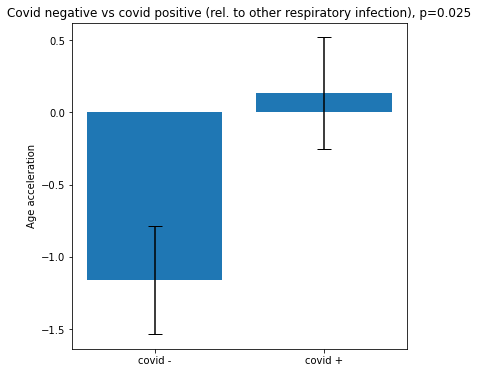

In [1110]:
covid_negative = data.diffs[data['covid_status:ch1'] == 'negative']
covid_positive = data.diffs[data['covid_status:ch1'] == 'positive']


p_val = stats.ttest_ind(covid_negative, covid_positive).pvalue

covid_negative_dev = stats.sem(covid_negative)
covid_positive_dev = stats.sem(covid_positive)
yer = [covid_negative_dev,covid_positive_dev]

covid_negative_mean = np.mean(covid_negative)
covid_positive_mean = np.mean(covid_positive)

height = [covid_negative_mean,covid_positive_mean]
bars = ['covid -', 'covid +']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration')
ax.set_title(('Covid negative vs covid positive (rel. to other respiratory infection), p={:.2g}').format(p_val))
plt.show()

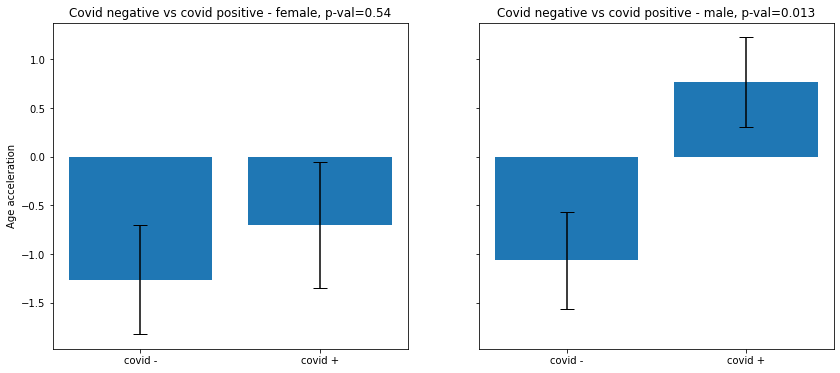

In [1109]:
covid_negative_f = data.diffs[(data['covid_status:ch1'] == 'negative') & (data['Sex:ch1'] == 'Female')]
covid_positive_f = data.diffs[(data['covid_status:ch1'] == 'positive') & (data['Sex:ch1'] == 'Female')]
covid_negative_m = data.diffs[(data['covid_status:ch1'] == 'negative') & (data['Sex:ch1'] == 'Male')]
covid_positive_m = data.diffs[(data['covid_status:ch1'] == 'positive') & (data['Sex:ch1'] == 'Male')]


p_val1 = stats.ttest_ind(covid_negative_f, covid_positive_f).pvalue
p_val2 = stats.ttest_ind(covid_negative_m, covid_positive_m).pvalue

covid_negative_dev1 = stats.sem(covid_negative_f)
covid_positive_dev1 = stats.sem(covid_positive_f)
yer1 = [covid_negative_dev1,covid_positive_dev1]

covid_negative_dev2 = stats.sem(covid_negative_m)
covid_positive_dev2 = stats.sem(covid_positive_m)
yer2 = [covid_negative_dev2,covid_positive_dev2]

covid_negative_mean1 = np.mean(covid_negative_f)
covid_positive_mean1 = np.mean(covid_positive_f)
covid_negative_mean2 = np.mean(covid_negative_m)
covid_positive_mean2 = np.mean(covid_positive_m)

height1 = [covid_negative_mean1,covid_positive_mean1]
height2 = [covid_negative_mean2,covid_positive_mean2]
bars = ['covid -', 'covid +']
y_pos = [1,2]


fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
  
axs[0].bar(y_pos,height1, yerr=yer1, capsize=7)
axs[0].set_ylabel('Age acceleration')
axs[0].set_xticks(y_pos)
axs[0].set_xticklabels(bars)
axs[0].set_title(('Covid negative vs covid positive - female, p-val={:.2g}').format(p_val1))

axs[1].bar(y_pos,height2, yerr=yer2, capsize=7)
axs[1].set_title(('Covid negative vs covid positive - male, p-val={:.2g}').format(p_val2))
axs[1].set_xticks(y_pos)
axs[1].set_xticklabels(bars)
_ = plt.plot()

<ipython-input-1171-4178b7ede354>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['severity score:ch1'][data2['severity score:ch1'].isna()] = 0


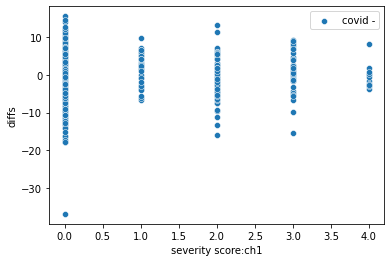

In [1171]:
data2 = data.copy()
data2['severity score:ch1'][data2['severity score:ch1'].isna()] = 0
severity = data2['severity score:ch1'][data2['severity score:ch1'].notna()]
epi_diffs = data2['diffs'][data2['severity score:ch1'].notna()]
sns.scatterplot(x=severity,y=epi_diffs,label='covid -')
_ = plt.plot()

Visually, severity score and epigenetic age differences don't seem to be correlated

In [ ]:
covid_negative_f = data.diffs[(data['covid_status:ch1'] == 'negative') & (data['Sex:ch1'] == 'Female')]
covid_positive_f = data.diffs[(data['covid_status:ch1'] == 'positive') & (data['Sex:ch1'] == 'Female')]
covid_negative_m = data.diffs[(data['covid_status:ch1'] == 'negative') & (data['Sex:ch1'] == 'Male')]
covid_positive_m = data.diffs[(data['covid_status:ch1'] == 'positive') & (data['Sex:ch1'] == 'Male')]


p_val1 = stats.ttest_ind(covid_negative_f, covid_positive_f).pvalue
p_val2 = stats.ttest_ind(covid_negative_m, covid_positive_m).pvalue

covid_negative_dev1 = stats.sem(covid_negative_f)
covid_positive_dev1 = stats.sem(covid_positive_f)
yer1 = [covid_negative_dev1,covid_positive_dev1]

covid_negative_dev2 = stats.sem(covid_negative_m)
covid_positive_dev2 = stats.sem(covid_positive_m)
yer2 = [covid_negative_dev2,covid_positive_dev2]

covid_negative_mean1 = np.mean(covid_negative_f)
covid_positive_mean1 = np.mean(covid_positive_f)
covid_negative_mean2 = np.mean(covid_negative_m)
covid_positive_mean2 = np.mean(covid_positive_m)

height1 = [covid_negative_mean1,covid_positive_mean1]
height2 = [covid_negative_mean2,covid_positive_mean2]
bars = ['covid -', 'covid +']
y_pos = [1,2]


fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
  
axs[0].bar(y_pos,height1, yerr=yer1, capsize=7)
axs[0].set_ylabel('Age acceleration')
axs[0].set_xticks(y_pos)
axs[0].set_xticklabels(bars)
axs[0].set_title(('Covid negative vs covid positive - female, p-val={:.2g}').format(p_val1))

axs[1].bar(y_pos,height2, yerr=yer2, capsize=7)
axs[1].set_title(('Covid negative vs covid positive - male, p-val={:.2g}').format(p_val2))
axs[1].set_xticks(y_pos)
axs[1].set_xticklabels(bars)
_ = plt.plot()

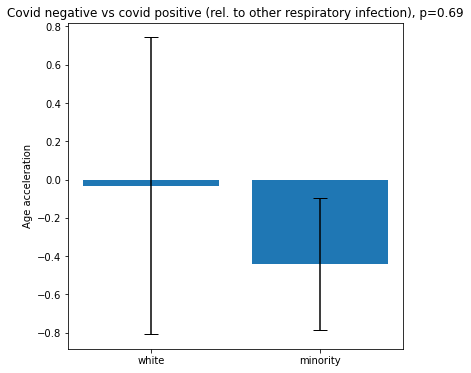

In [1137]:
# Grouped the samples by white vs minority since the samples were from america

white = data['diffs'][(data['race:ch1'] == 'White') & (data['ethnicity:ch1'] == 'Not Hispanic or Latino') & (data['covid_status:ch1'] == 'positive')]
minority = data['diffs'][(data['race:ch1'] != 'White') | (data['ethnicity:ch1'] != 'Not Hispanic or Latino') & (data['covid_status:ch1'] == 'positive')]


p_val = stats.ttest_ind(white, minority).pvalue

white_dev = stats.sem(white)
minority_dev = stats.sem(minority)
yer = [white_dev,minority_dev ]

white_mean = np.mean(white)
minority_mean = np.mean(minority)

height = [white_mean ,minority_mean]
bars = ['white', 'minority']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration')
ax.set_title(('Covid negative vs covid positive (rel. to other respiratory infection), p={:.2g}').format(p_val))
plt.show()

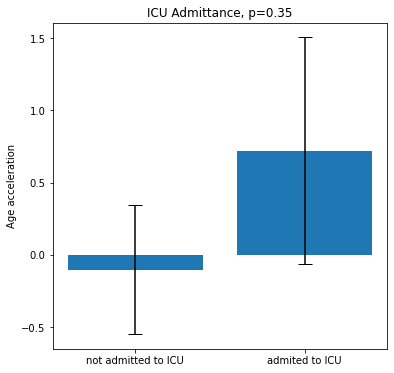

In [1147]:
not_admitted_to_icu = data['diffs'][(data['admitted_to_icu:ch1'] == 'No')& (data['covid_status:ch1'] == 'positive')]
admitted_to_icu = data['diffs'][(data['admitted_to_icu:ch1'] == 'Yes')& (data['covid_status:ch1'] == 'positive')]


p_val = stats.ttest_ind(not_admitted_to_icu, admitted_to_icu).pvalue

not_admitted_to_icu_dev = stats.sem(not_admitted_to_icu)
admitted_to_icu_dev = stats.sem(admitted_to_icu)
yer = [not_admitted_to_icu_dev,admitted_to_icu_dev]

not_admitted_to_icu_mean = np.mean(not_admitted_to_icu)
admitted_to_icu_mean = np.mean(admitted_to_icu)

height = [not_admitted_to_icu_mean ,admitted_to_icu_mean]
bars = ['not admitted to ICU', 'admited to ICU']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration')
ax.set_title(('ICU Admittance, p={:.2g}').format(p_val))
plt.show()

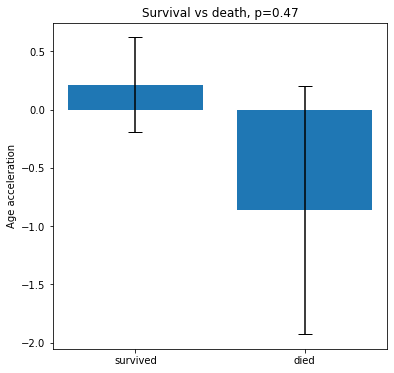

In [1160]:
survived = data['diffs'][(data['discharged_to:ch1'] != 'Death')& (data['covid_status:ch1'] == 'positive')]
died = data['diffs'][(data['discharged_to:ch1'] == 'Death')& (data['covid_status:ch1'] == 'positive')]


p_val = stats.ttest_ind(survived, died).pvalue

survived_dev = stats.sem(survived)
died_dev = stats.sem(died)
yer = [survived_dev,died_dev]

survived_mean = np.mean(survived)
died_mean = np.mean(died)

height = [survived_mean,died_mean]
bars = ['survived', 'died']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration')
ax.set_title(('Survival vs death, p={:.2g}').format(p_val))
plt.show()

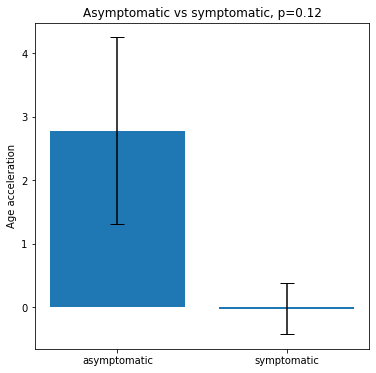

In [1211]:
asymptomatic = data['diffs'][(data['patient_asymptomatic:ch1'] == 'Yes')& (data['covid_status:ch1'] == 'positive')]
symptomatic = data['diffs'][(data['patient_asymptomatic:ch1'] == 'No')& (data['covid_status:ch1'] == 'positive')]


p_val = stats.ttest_ind(asymptomatic, symptomatic).pvalue

asymptomatic_dev = stats.sem(asymptomatic)
symptomatic_dev = stats.sem(symptomatic)
yer = [asymptomatic_dev,symptomatic_dev]

asymptomatic_mean = np.mean(asymptomatic)
symptomatic_mean = np.mean(symptomatic)

height = [asymptomatic_mean,symptomatic_mean]
bars = ['asymptomatic', 'symptomatic']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration')
ax.set_title(('Asymptomatic vs symptomatic, p={:.2g}').format(p_val))
plt.show()

Looks potentially interesting, but there are only 8 asymptomatic samples

Trying out another dataset:

In [1215]:
goldstandardvals = pd.read_csv('HorvathClock/probeAnnotation21kdatMethUsed.csv')

data_meta = pd.read_csv('data/covidGSE174818_meta.csv')
data_norm = pd.read_csv('data/covidGSE174818_normalized.csv')

missing_cpgs = []
for cpg in AltumAge_cpgs:
    if cpg not in data_norm.columns:
        data_norm[cpg] = float(goldstandardvals.goldstandard2[goldstandardvals.Name == cpg])
        missing_cpgs.append(cpg)
if missing_cpgs:        
    print(('{} probes out of {} necessary for calculating epigenetic age with AltumAge are missing.' 
          ' Added them in with values from probeannotation file, but the age predictions for this dataset will' 
          ' not be comparable with other datasets.').format(len(missing_cpgs), len(AltumAge_cpgs)))

data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge2 = AltumAge.predict(methylation_data_scaled).flatten()

12 probes out of 20318 necessary for calculating epigenetic age with AltumAge are missing. Added them in with values from probeannotation file, but the age predictions for this dataset will not be comparable with other datasets.


In [1216]:
chrono_age = data_meta['age:ch1']

In [1217]:
data_meta

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_country,supplementary_file,supplementary_file.1,data_row_count,age:ch1,covid status:ch1,death:ch1,race:ch1,Sex:ch1,tissue:ch1
GSM5331993,COVID_72,GSM5331993,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_72,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,50,1,0,H,F,blood
GSM5331994,COVID_84,GSM5331994,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_84,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,75,1,0,W,F,blood
GSM5331995,COVID_96,GSM5331995,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_96,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,51,1,0,W,M,blood
GSM5331996,COVID_83,GSM5331996,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_83,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,85,1,1,W,F,blood
GSM5331997,COVID_95,GSM5331997,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_95,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,49,1,0,O,M,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5332116,COVID_22,GSM5332116,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_22,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,43,1,1,H,M,blood
GSM5332117,COVID_34,GSM5332117,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_34,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,64,1,0,O,F,blood
GSM5332118,COVID_46,GSM5332118,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_46,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,62,1,0,W,M,blood
GSM5332119,COVID_59,GSM5332119,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_59,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,55,1,0,W,M,blood


C:\Users\olyam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


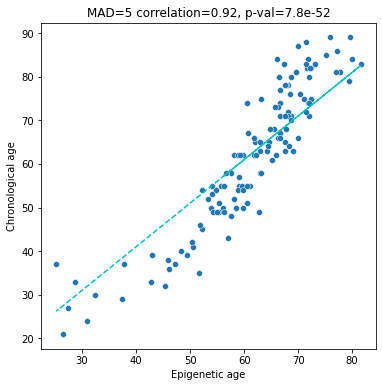

In [1218]:
plot_epi_chrono(pred_age_AltumAge2, chrono_age)

C:\Users\olyam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


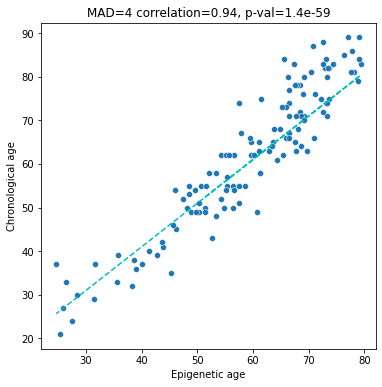

In [1224]:
adjusted_altum_preds2 = p(pred_age_AltumAge2)
diffs = adjusted_altum_preds2 - chrono_age
plot_epi_chrono(adjusted_altum_preds2, chrono_age)

In [1236]:
covid_negative = diffs[(data_meta['covid status:ch1'] == 1) &  (data_meta['race:ch1'] == 'W')]
covid_positive = diffs[(data_meta['covid status:ch1'] == 1) & (data_meta['race:ch1'] != 'W')]

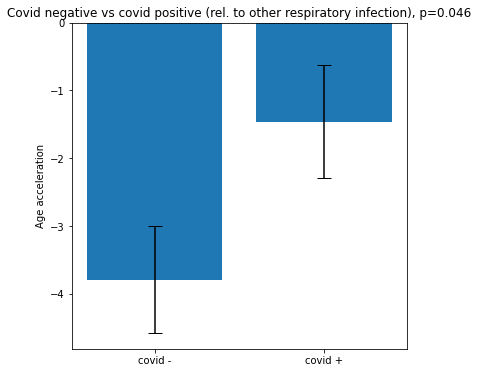

In [1237]:

p_val = stats.ttest_ind(covid_negative, covid_positive).pvalue

covid_negative_dev = stats.sem(covid_negative)
covid_positive_dev = stats.sem(covid_positive)
yer = [covid_negative_dev,covid_positive_dev]

covid_negative_mean = np.mean(covid_negative)
covid_positive_mean = np.mean(covid_positive)

height = [covid_negative_mean,covid_positive_mean]
bars = ['covid -', 'covid +']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration')
ax.set_title(('Covid negative vs covid positive (rel. to other respiratory infection), p={:.2g}').format(p_val))
plt.show()

In [1227]:
data_meta

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_country,supplementary_file,supplementary_file.1,data_row_count,age:ch1,covid status:ch1,death:ch1,race:ch1,Sex:ch1,tissue:ch1
GSM5331993,COVID_72,GSM5331993,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_72,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,50,1,0,H,F,blood
GSM5331994,COVID_84,GSM5331994,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_84,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,75,1,0,W,F,blood
GSM5331995,COVID_96,GSM5331995,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_96,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,51,1,0,W,M,blood
GSM5331996,COVID_83,GSM5331996,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_83,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,85,1,1,W,F,blood
GSM5331997,COVID_95,GSM5331997,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_95,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5331...,0,49,1,0,O,M,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM5332116,COVID_22,GSM5332116,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_22,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,43,1,1,H,M,blood
GSM5332117,COVID_34,GSM5332117,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_34,Homo sapiens,Sex: F,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,64,1,0,O,F,blood
GSM5332118,COVID_46,GSM5332118,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_46,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,62,1,0,W,M,blood
GSM5332119,COVID_59,GSM5332119,Public on May 31 2021,May 23 2021,May 31 2021,genomic,1,COVID_59,Homo sapiens,Sex: M,...,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5332...,0,55,1,0,W,M,blood
